In [6]:
import time
from cs336_scaling.common import (
    get_chinchilla_power_law_n_for_c,
    get_chinchilla_n_for_c,
    pick_candidates_around_n,
    get_shape_given_n,
    print_predicted_shapes,
    get_chinchilla_lr_for_n,
    get_shape_for_n_custom,
    power_law,
)

from cs336_scaling.constants import VOCAB_SIZE, BATCH_SIZE, FLOPS_BUDGET
from cs336_scaling.training_api import get_loss, sync_api_state, get_total_flops_used
from cs336_scaling.analyze import (
    best_run_where,
    fit_quadratic,
    find_optimal_params,
    plot_runs,
    get_all_runs,
    plot_loss_vs_lr_at_c_and_n,
    group_by,
    plot_tokens_per_param_vs_loss,
    best_lr_per_n,
)

from scipy.optimize import curve_fit

import numpy as np

In [5]:
def print_flops_stats(total_flops_used: float | None = None):
    if total_flops_used is None:
        total_flops_used = get_total_flops_used()

    print(f"Total FLOPs Used: {total_flops_used:.2e}")
    print(f"Total FLOPs Used (%): {total_flops_used * 100 / FLOPS_BUDGET:.3f}")
    print("-" * 100)


def print_stats_at_c(
    c: float,
    all_runs: list[dict] | None = None,
    best_n: int | None = None,
    sync_api: bool = False,
    best_lr_per_n: bool = True,
):
    if all_runs is None and sync_api is False:
        raise ValueError("Must provide either all_runs or sync_api")

    if sync_api:
        all_runs, total_flops_used = sync_api_state()

    runs_at_c = [run for run in all_runs if run["train_flops"] == c]

    if len(runs_at_c) == 0:
        print(f"No runs found for C = {c:.0e}")
        return

    runs_to_fit = runs_at_c

    if best_lr_per_n:
        group_by_n = group_by(runs_at_c, "est_n_non_embedding")
        for n in group_by_n:
            group_by_n[n] = sorted(group_by_n[n], key=lambda x: x["loss"])[0]

        runs_to_fit = list(group_by_n.values())

    if best_n is not None:
        runs_to_fit = sorted(runs_at_c, key=lambda x: x["loss"])[:best_n]

    fit_fn = fit_quadratic(runs_to_fit)
    coeffs = fit_fn.coeffs
    best_run = min(runs_at_c, key=lambda x: x["loss"])
    best_run_n = best_run["est_n_non_embedding"]
    best_run_n_total = best_run["est_n_total"]
    chinchilla_lr = get_chinchilla_lr_for_n(best_run_n_total)
    pred_opt_n = find_optimal_params(fit_fn)
    pred_opt_loss = fit_fn(np.log(pred_opt_n))

    print(f"Best for C = {c:.0e}:")

    print(f"- Non-embedding params: {best_run_n:.2e} ({best_run_n} params)")
    print(f"- LR: {best_run['learning_rate']:.3e} (chinchilla: {chinchilla_lr:.3e})")
    print(f"- Loss: {best_run['loss']:.5f}")
    print(f"- Total params: {best_run_n_total:.2e} ({best_run_n_total} params)")
    print(f"- Embedding ratio: {best_run['est_embed_ratio']:.2f}")
    print(
        f"- Tokens: {best_run['est_tokens']:.2e} ({int(best_run['est_tokens'])} tokens)"
    )
    print(f"- Tokens per param (D/N): {best_run['est_tokens_per_param']:.3f}")
    print(f"- Aspect ratio: {best_run['d_model'] / best_run['num_layers']:.2f}")
    print(best_run)
    print("-" * 100)

    print(f"Quadratic fit for all runs at {c:.0e} FLOPs:")
    print(f"{coeffs[0]:.4f}x^2 + {coeffs[1]:.4f}x + {coeffs[2]:.4f}")

    print(f"Pred. optimal params: {pred_opt_n:.2e}")
    print(f"Pred. loss at optimal params: {pred_opt_loss:.5f}")

    print("-" * 100)

In [3]:
def sweep_n_at_c(c: float, n_guess: int, factor: float = 5, n_candidates: int = 5, dry_run: bool = False):
    candidates = pick_candidates_around_n(
        n_guess, factor=factor, n_candidates=n_candidates, round_to_int=True
    )
    print_predicted_shapes(ns=candidates, c=c)

    for n in candidates:
        d, L, h, n_star = get_shape_given_n(n)
        lr = get_chinchilla_lr_for_n(n_star)
        bs = BATCH_SIZE

        # res = {"loss": 0.0, "total_flops_used": 0}

        if dry_run:
            print(f"Would run with N={n:.2e}, lr={lr:.3e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()


def sweep_lr_at_cn(
    c: int, n: int, lr_guess: float, factor: float = 3, n_candidates: int = 5, dry_run: bool = False
):
    lr_candidates = pick_candidates_around_n(
        lr_guess, factor=factor, n_candidates=n_candidates, round_to_int=False
    )
    lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

    for lr in lr_candidates:
        d, L, h, n_star = get_shape_given_n(n)
        bs = BATCH_SIZE

        if dry_run:
            print(f"Would run with lr={lr:.3e}, N={n:.2e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()

N_1_total_guess: 2.89e+06 (error: 1.31e+06 = 45.29%)
N_1_guess: 9.83e+04 (98304)
CANDIDATE: 9.83e+04 (98304)
Computed shapes:
  idx	     c	       n	  n_star	     err	err_pct	   tok/n	   d	  L	  d/L	  h	  pred_lr	embed_ratio	   tokens	tok/n_star
    0	 1e+15	9.83e+03	9.83e+04	8.85e+04	900.04%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    1	 1e+15	1.37e+04	9.83e+04	8.46e+04	619.70%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    2	 1e+15	1.90e+04	9.83e+04	7.93e+04	417.93%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    3	 1e+15	2.64e+04	9.83e+04	7.19e+04	272.76%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    4	 1e+15	3.66e+04	9.83e+04	6.17e+04	168.27%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    5	 1e+15	5.09e+04	9.83e+04	4.74e+04	 93.07%	    9.47	  64	  2	32.00	  2	 6.67e-04	     0.98	 3.97e+07	  404.22
    6	 1e+15	7.07e+04	9.83e+04	2.76e+04	 38.95%	    9.47	  64	  2

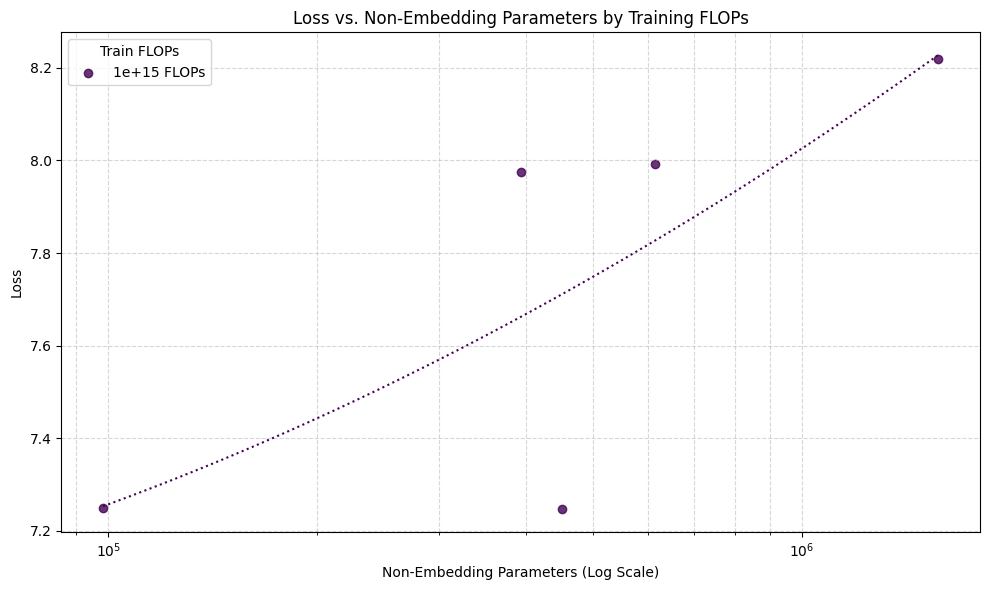

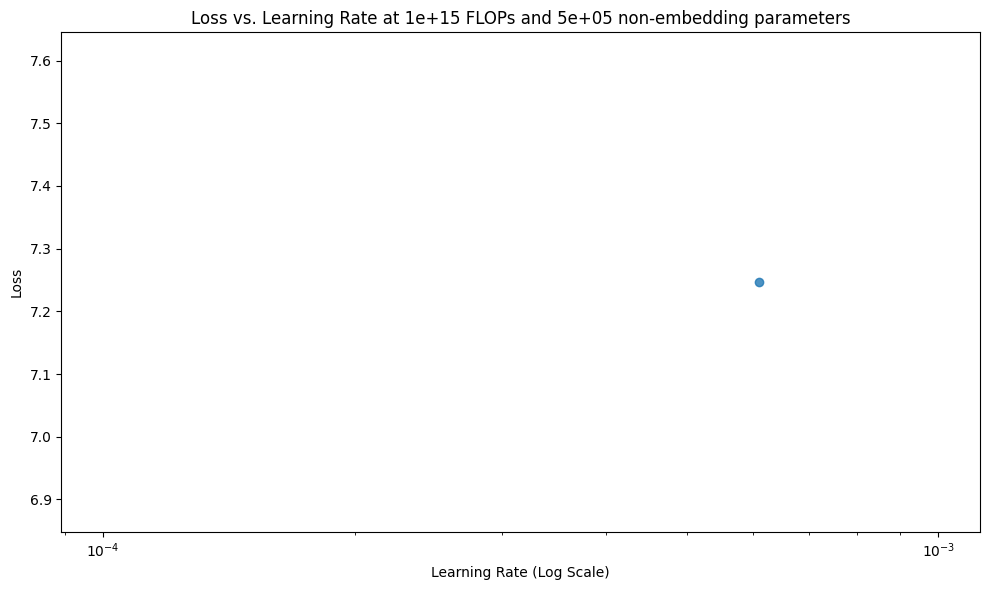

In [17]:
# INITIAL RUNS CENTERED AROUND HOFFMAN/2 GUESS (running one at a time to save FLOPs)

best_run_at_3e16 = best_run_where("train_flops", 3e16)

def get_lr(n_total):
    return (
        best_run_at_3e16["learning_rate"]
        * (n_total / best_run_at_3e16["est_n_total"]) ** -0.15
    )

C_1 = 1e15
min_aspect_ratio = 24
max_aspect_ratio = 64

# Get total param count if we want to hit 20 tokens/param
N_1_total_guess = get_chinchilla_n_for_c(C_1, tokens_per_param=20)

# Get a shape that approximately realizes N_1_total_guess
d, L, h, n_realized_total, err, err_pct = get_shape_for_n_custom(
    N_1_total_guess,
    min_aspect_ratio=min_aspect_ratio,
    max_aspect_ratio=max_aspect_ratio,
    n_is_total=True,
)
print(f"N_1_total_guess: {N_1_total_guess:.2e} (error: {err:.2e} = {err_pct:.2f}%)")

# Estimate the non-embedding parameter count in the realised shape
N_1_guess = 12 * L * d**2
print(f"N_1_guess: {N_1_guess:.2e} ({N_1_guess})")

# Get a list of candidate N values to try around the *non-embedding* parameter count
candidates = pick_candidates_around_n(
    N_1_guess, factor=10, n_candidates=15, round_to_int=True
)

# Compute the ratio (same between all candidates) in case we want to extend the list
# ratio = candidates[-1] / candidates[-2]

# Process candidates one at a time, checking results after each (to determine where to explore next)
candidate = N_1_guess
# candidate = candidates[14]
# candidate = candidates[6] # (~27 tok/param

print(f"CANDIDATE: {candidate:.2e} ({candidate})")

print_predicted_shapes(
    ns=candidates,
    get_shape_fn=lambda n: get_shape_for_n_custom(
        n, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
    ),
    get_lr_fn=get_lr,
    c=C_1,
)
# ================================

d, L, h, n_realized, *_ = get_shape_for_n_custom(
    candidate, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
)
n_embed = 2 * VOCAB_SIZE * d
n_total = n_realized + n_embed

# lr = 9e-4
lr = get_lr(n_total)
# lr = 3.5e-4
bs = BATCH_SIZE

print(d, L, h, n_realized, n_embed, n_total, lr, bs)

res = {"loss": 0.0, "total_flops_used": 0}

res = get_loss(
    d_model=d,
    num_layers=L,
    num_heads=h,
    batch_size=bs,
    learning_rate=lr,
    train_flops=C_1,
)

if "loss" not in res:
    print(res)

all_runs = get_all_runs(sync_api=True)
runs_at_c = [run for run in all_runs if run["train_flops"] == C_1]
best_run = min(runs_at_c, key=lambda x: x["loss"]) if runs_at_c else None

print_stats_at_c(c=C_1, all_runs=runs_at_c, best_n=10)

print_flops_stats()
if len(runs_at_c) > 0:
    plot_runs(runs_at_c, best_n_per_c=10, outfile_suffix=f"_{C_1}")
    plot_loss_vs_lr_at_c_and_n(C_1, best_run["est_n_non_embedding"])

In [ ]:
# REFINEMENT RUNS CENTERED AROUND N_1_OPT_SO_FAR (factor=2)
# From best run at C_1 (which was better than quadratic pred. optimal)
N_1_opt_so_far = best_run_where("train_flops", C_1)["est_n_non_embedding"]
sweep_n_at_c(C_1, N_1_opt_so_far, factor=2, n_candidates=5, dry_run=True)

In [ ]:
# LEARNING RATE EXPLORATION USING N_1_OPT_SO_FAR
# From new best run at C_1 (better than quadratic pred. optimal)
N_1_opt_so_far = 884736
lr_guess = get_chinchilla_lr_for_n(N_1_opt_so_far)
sweep_lr_at_cn(C_1, N_1_opt_so_far, lr_guess, factor=4, n_candidates=11, dry_run=True)

In [ ]:
# LEARNING RATE REFINEMENT EXPLORATION USING LR_OPT_SO_FAR (for N_1_OPT_SO_FAR)
# From new best run at C_1 (better than quadratic pred. optimal)
N_1_opt_so_far = 884736
lr_opt_so_far = 5.391e-04
sweep_lr_at_cn(C_1, N_1_opt_so_far, lr_opt_so_far, factor=1.5, n_candidates=5, dry_run=True)